# 03.3 - Feature Refinement

This notebook refines the feature set by:
- Adjusting rolling window sizes to reduce correlation between similar features
- Removing redundant circuit-specific position features (keep only podium rates)
- Creating optimized window sizes for different feature types

**Changes:**
- Keep `driver_podium_rate_last_10` (no change)
- Replace `driver_avg_grid_last_10` with `driver_avg_grid_last_5` (qualifying is more volatile)
- Replace `constructor_podium_rate_last_10` with `constructor_podium_rate_last_15` (team performance is more stable)
- Remove `driver_avg_position_at_circuit` and `constructor_avg_position_at_circuit` (keep only podium rates)

**Input:** `data/processed/master_races_final.csv` (from 03.6)  
**Output:** Refined dataset with optimized feature windows


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up paths
# Get project root (works whether running from notebooks/ or F1/ folder)
PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent

PROCESSED_ROOT = PROJECT_ROOT / "data" / "processed"

# Load final dataset from 03.6
final_file = PROCESSED_ROOT / "master_races_final.csv"
if not final_file.exists():
    print(f"ERROR: {final_file} not found!")
    print("Please run notebook 03.6_feature_selection.ipynb first.")
    raise FileNotFoundError(f"Required file not found: {final_file}")

print(f"Loading final dataset from: {final_file}")
master = pd.read_csv(final_file)
master['date'] = pd.to_datetime(master['date'], errors='coerce')

# Sort by date to ensure proper temporal ordering
master = master.sort_values(['year', 'round', 'date']).reset_index(drop=True)

print(f"✓ Loaded successfully: {master.shape[0]:,} rows × {master.shape[1]} columns")
print(f"Date range: {master['date'].min()} to {master['date'].max()}")

# Also load original data to create new features
original_file = PROCESSED_ROOT / "master_races.csv"
print(f"\nLoading original data from: {original_file}")
original = pd.read_csv(original_file)
original['date'] = pd.to_datetime(original['date'], errors='coerce')
original = original.sort_values(['year', 'round', 'date']).reset_index(drop=True)
print(f"✓ Original data loaded: {original.shape[0]:,} rows × {original.shape[1]} columns")

# Set plotting style
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)


Loading final dataset from: C:\Users\erikv\Downloads\F1\data\processed\master_races_final.csv
✓ Loaded successfully: 12,358 rows × 102 columns
Date range: 1994-03-27 00:00:00 to 2024-12-08 00:00:00

Loading original data from: C:\Users\erikv\Downloads\F1\data\processed\master_races.csv
✓ Original data loaded: 12,358 rows × 82 columns


## 1. Remove Old Window Features

Remove the features we're replacing with different window sizes.


In [2]:
# Remove features we're replacing
features_to_remove = [
    'driver_avg_grid_last_10',      # Replace with _last_5
    'constructor_podium_rate_last_10',  # Replace with _last_15
    'driver_avg_position_at_circuit',    # Remove (keep only podium rate)
    'constructor_avg_position_at_circuit',  # Remove (keep only podium rate)
]

print("Removing features to be replaced/removed:")
removed_count = 0
for col in features_to_remove:
    if col in master.columns:
        print(f"  - {col}")
        master = master.drop(columns=[col])
        removed_count += 1
    else:
        print(f"  - {col} (not found, skipping)")

print(f"\nRemoved {removed_count} features. New shape: {master.shape}")


Removing features to be replaced/removed:
  - driver_avg_grid_last_10
  - constructor_podium_rate_last_10
  - driver_avg_position_at_circuit
  - constructor_avg_position_at_circuit

Removed 4 features. New shape: (12358, 98)


## 2. Create driver_avg_grid_last_5

Create driver average grid position over last 5 races (instead of 10). Qualifying performance is more volatile and recent form is more relevant.


In [3]:
# Create driver_avg_grid_last_5 from original data
# Need to align by raceId to ensure proper matching
if 'grid' in original.columns and 'driverId' in original.columns and 'raceId' in master.columns:
    # Ensure both are sorted the same way
    original_sorted = original.sort_values(['year', 'round', 'date']).reset_index(drop=True)
    
    # Create the feature in original dataframe
    original_sorted['driver_avg_grid_last_5'] = (
        original_sorted.groupby('driverId')['grid']
        .shift(1)  # Exclude current race
        .rolling(window=5, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # Merge with master using raceId and driverId to ensure proper alignment
    if 'driverId' in master.columns:
        # Create a temporary dataframe with the feature
        temp_df = original_sorted[['raceId', 'driverId', 'driver_avg_grid_last_5']].copy()
        
        # Merge with master
        master = master.merge(
            temp_df,
            on=['raceId', 'driverId'],
            how='left',
            suffixes=('', '_new')
        )
        
        # If column already exists from merge, use the new one
        if 'driver_avg_grid_last_5_new' in master.columns:
            master['driver_avg_grid_last_5'] = master['driver_avg_grid_last_5_new']
            master = master.drop(columns=['driver_avg_grid_last_5_new'])
        
        print("✓ Created driver_avg_grid_last_5")
        print(f"  Non-null values: {master['driver_avg_grid_last_5'].notna().sum():,}")
        print(f"  Mean value: {master['driver_avg_grid_last_5'].mean():.2f}")
    else:
        print("ERROR: driverId not found in master dataframe")
else:
    print("ERROR: Required columns not found")
    if 'grid' not in original.columns:
        print("  - grid not in original")
    if 'driverId' not in original.columns:
        print("  - driverId not in original")
    if 'raceId' not in master.columns:
        print("  - raceId not in master")


✓ Created driver_avg_grid_last_5
  Non-null values: 12,330
  Mean value: 11.02


## 3. Create constructor_podium_rate_last_15

Create constructor podium rate over last 15 races (instead of 10). Team performance is more stable and longer windows capture better trends.


In [4]:
# Create constructor_podium_rate_last_15 from original data
# First need to create podium target in original data
if 'positionOrder' in original.columns and 'constructorId' in original.columns and 'raceId' in master.columns:
    original_sorted = original.sort_values(['year', 'round', 'date']).reset_index(drop=True)
    original_sorted['podium'] = (original_sorted['positionOrder'] <= 3).astype(int)
    
    # Create the feature in original dataframe
    original_sorted['constructor_podium_rate_last_15'] = (
        original_sorted.groupby('constructorId')['podium']
        .shift(1)  # Exclude current race
        .rolling(window=15, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # Merge with master using raceId and constructorId to ensure proper alignment
    if 'constructorId' in master.columns:
        # Create a temporary dataframe with one row per (raceId, constructorId)
        temp_df = (
            original_sorted[['raceId', 'constructorId', 'constructor_podium_rate_last_15']]
            .sort_values(['raceId', 'constructorId'])
            .groupby(['raceId', 'constructorId'], as_index=False)['constructor_podium_rate_last_15']
            .last()
        )
        
        # Merge with master
        master = master.merge(
            temp_df,
            on=['raceId', 'constructorId'],
            how='left',
            suffixes=('', '_new')
        )
        
        # If column already exists from merge, use the new one
        if 'constructor_podium_rate_last_15_new' in master.columns:
            master['constructor_podium_rate_last_15'] = master['constructor_podium_rate_last_15_new']
            master = master.drop(columns=['constructor_podium_rate_last_15_new'])
        
        print("✓ Created constructor_podium_rate_last_15")
        print(f"  Non-null values: {master['constructor_podium_rate_last_15'].notna().sum():,}")
        print(f"  Mean value: {master['constructor_podium_rate_last_15'].mean():.4f}")
        print(f"  Unique (raceId, constructorId) pairs: {temp_df.shape[0]:,}")
    else:
        print("ERROR: constructorId not found in master dataframe")
else:
    print("ERROR: Required columns not found")
    if 'positionOrder' not in original.columns:
        print("  - positionOrder not in original")
    if 'constructorId' not in original.columns:
        print("  - constructorId not in original")
    if 'raceId' not in master.columns:
        print("  - raceId not in master")


✓ Created constructor_podium_rate_last_15
  Non-null values: 12,358
  Mean value: 0.1366
  Unique (raceId, constructorId) pairs: 6,185


## 4. Summary of Changes

Summary of all feature modifications.


In [5]:
# Load original final dataset to compare
original_final = pd.read_csv(final_file)
removed_features = [col for col in original_final.columns if col not in master.columns]
added_features = [col for col in master.columns if col not in original_final.columns]

print("="*70)
print("FEATURE REFINEMENT SUMMARY")
print("="*70)
print(f"\nOriginal final shape: {original_final.shape}")
print(f"Refined shape: {master.shape}")
print(f"Features removed: {len(removed_features)}")
print(f"Features added: {len(added_features)}")

print("\n" + "="*70)
print("FEATURES REMOVED")
print("="*70)
for feat in sorted(removed_features):
    print(f"  - {feat}")

print("\n" + "="*70)
print("FEATURES ADDED")
print("="*70)
for feat in sorted(added_features):
    print(f"  - {feat}")

print("\n" + "="*70)
print("ROLLING WINDOW FEATURES (FINAL)")
print("="*70)
rolling_features = [f for f in master.columns if '_last_' in f]
for feat in sorted(rolling_features):
    window = feat.split('_last_')[-1] if '_last_' in feat else 'N/A'
    print(f"  {feat:50s} (window: {window})")

print("\n" + "="*70)
print("CIRCUIT-SPECIFIC FEATURES (FINAL)")
print("="*70)
circuit_features = [f for f in master.columns if 'circuit' in f.lower() and '_at_circuit' in f]
for feat in sorted(circuit_features):
    print(f"  - {feat}")

print("\n" + "="*70)


FEATURE REFINEMENT SUMMARY

Original final shape: (12358, 102)
Refined shape: (12358, 100)
Features removed: 4
Features added: 2

FEATURES REMOVED
  - constructor_avg_position_at_circuit
  - constructor_podium_rate_last_10
  - driver_avg_grid_last_10
  - driver_avg_position_at_circuit

FEATURES ADDED
  - constructor_podium_rate_last_15
  - driver_avg_grid_last_5

ROLLING WINDOW FEATURES (FINAL)
  constructor_podium_rate_last_15                    (window: 15)
  disqualified_rate_last_10                          (window: 10)
  dnf_rate_last_10                                   (window: 10)
  driver_avg_grid_last_5                             (window: 5)
  driver_avg_position_last_3                         (window: 3)
  driver_avg_position_last_5                         (window: 5)
  driver_podium_rate_last_10                         (window: 10)
  driver_points_avg_last_10                          (window: 10)
  driver_sprint_points_avg_last_5                    (window: 5)
  finished_l

Features selected for correlation analysis: 20
Features: podium, grid, driver_standings_points_PRE_RACE, driver_standings_position_PRE_RACE, constructor_standings_position_PRE_RACE, driver_points_avg_last_10, driver_podium_rate_last_10, driver_avg_grid_last_5, constructor_podium_rate_last_15, dnf_rate_last_10...


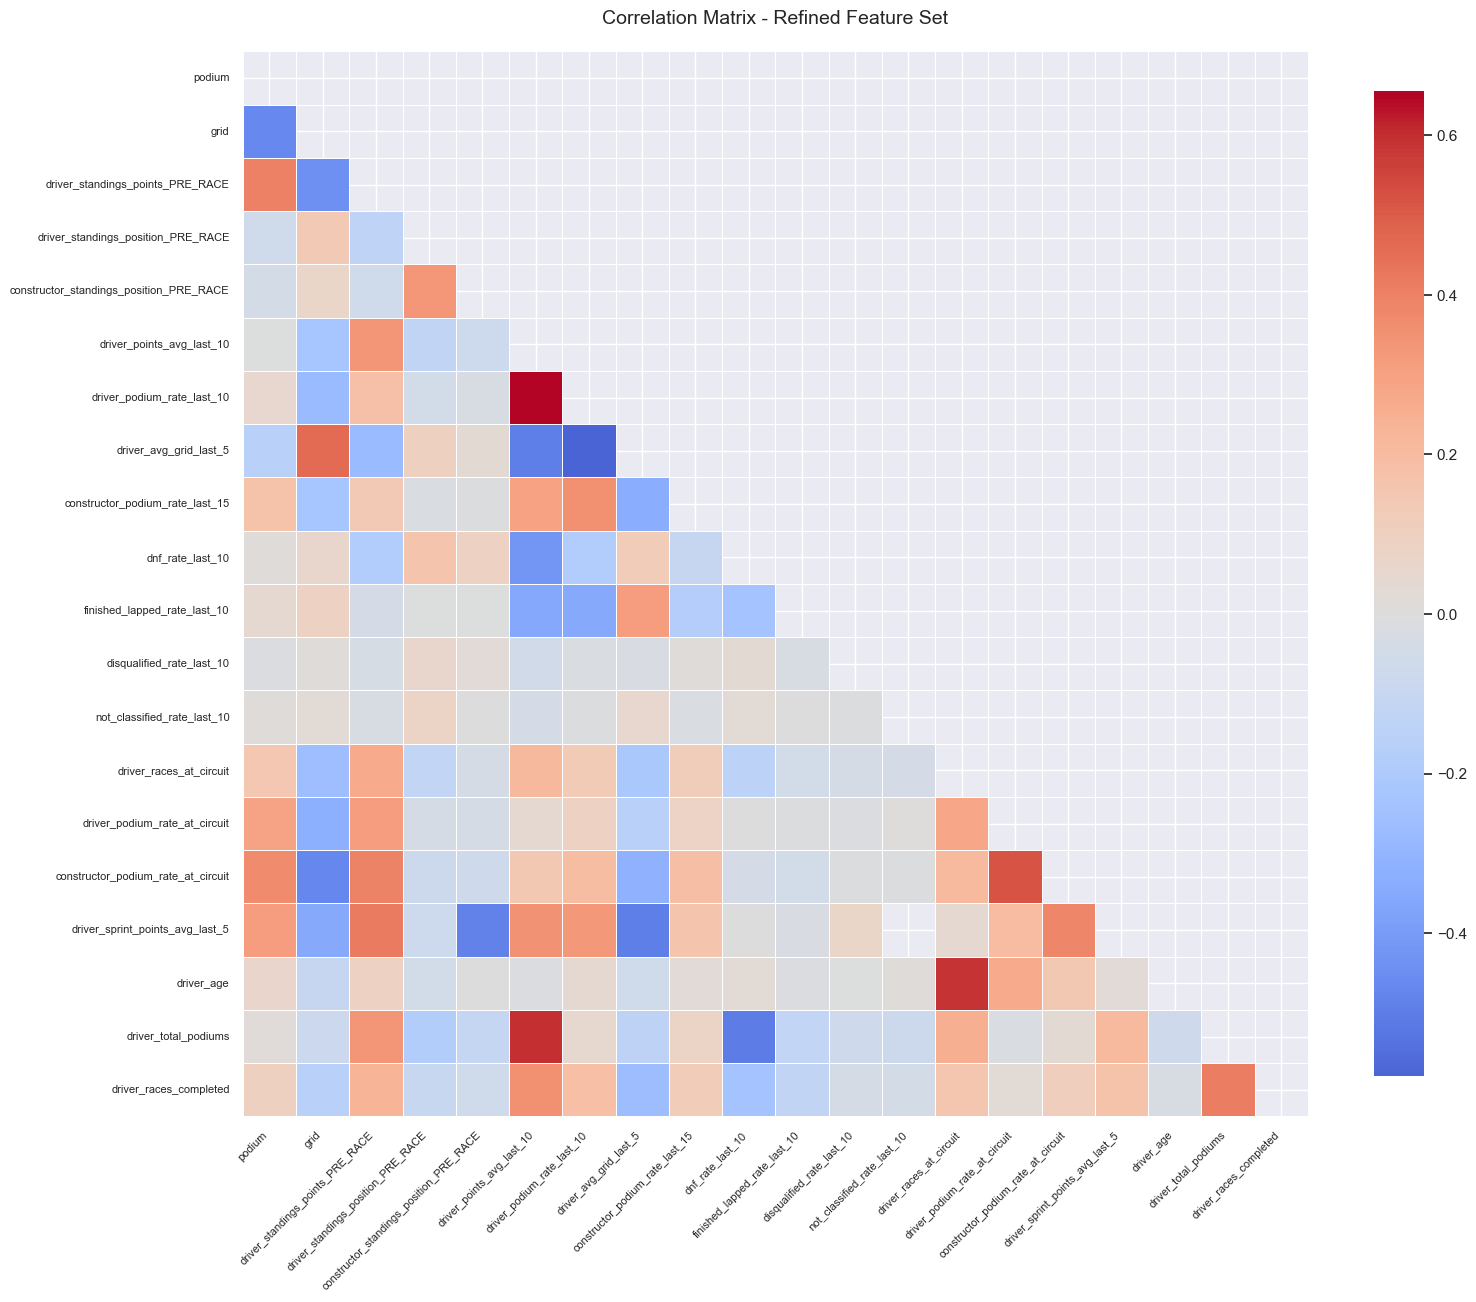


HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)
These features may still be redundant - consider further review

No highly correlated pairs found (|r| > 0.7)
✓ Excellent! Features are relatively independent

TOP CORRELATIONS WITH PODIUM

Top 20 features most correlated with podium:
  grid                                               : -0.469 (negative)
  driver_standings_points_PRE_RACE                   :  0.401 (positive)
  constructor_podium_rate_at_circuit                 :  0.367 (positive)
  driver_sprint_points_avg_last_5                    :  0.315 (positive)
  driver_podium_rate_at_circuit                      :  0.293 (positive)
  constructor_podium_rate_last_15                    :  0.173 (positive)
  driver_avg_grid_last_5                             : -0.161 (negative)
  driver_races_at_circuit                            :  0.153 (positive)
  driver_races_completed                             :  0.099 (positive)
  driver_age                                         :  0.063 (

In [ ]:
# Select key numeric features for correlation analysis
# NOTE: Excluding outcome features (points, position, etc.) to avoid data leakage in analysis
key_features = [
    # Target
    'podium',
    # Original strong predictors (pre-race only)
    'grid',  # Grid position is known before race
    # NOTE: 'points' excluded - it's a race outcome, not a predictor
    # Pre-race standings
    'driver_standings_points_PRE_RACE', 'driver_standings_position_PRE_RACE',
    'constructor_standings_position_PRE_RACE',
    # Rolling points
    'driver_points_avg_last_10',
    # Driver rolling features
    'driver_podium_rate_last_10',
    'driver_avg_grid_last_5',  # NEW: Changed from _last_10
    # Constructor rolling features
    'constructor_podium_rate_last_15',  # NEW: Changed from _last_10
    # Status rates
    'dnf_rate_last_10',
    'finished_lapped_rate_last_10',
    'disqualified_rate_last_10',
    'not_classified_rate_last_10',
    # Circuit features (only podium rates now)
    'driver_races_at_circuit',
    'driver_podium_rate_at_circuit',
    'constructor_podium_rate_at_circuit',
    # Season trends
    'driver_position_trend_season',
    # Sprint features
    'driver_sprint_points_avg_last_5',
    # NEW: Add these three features
    'driver_age',
    'driver_total_podiums',
    'driver_races_completed',
]

# Filter to features that exist in the dataset
available_features = [f for f in key_features if f in master.columns]
numeric_available = [f for f in available_features if master[f].dtype in [np.int64, np.float64]]

# Explicitly exclude positionOrder from correlation analysis (outcome variable, not a predictor)
if 'positionOrder' in numeric_available:
    numeric_available.remove('positionOrder')
    print("  Note: Excluding 'positionOrder' from correlation analysis (outcome variable)")

print(f"Features selected for correlation analysis: {len(numeric_available)}")
print(f"Features: {', '.join(numeric_available[:10])}...")

# Calculate correlation matrix
if len(numeric_available) > 1:
    feature_corr = master[numeric_available].corr()
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(feature_corr, dtype=bool))
    
    # Plot correlation heatmap
    plt.figure(figsize=(16, 14))
    sns.heatmap(feature_corr, mask=mask, annot=False, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                xticklabels=feature_corr.columns, yticklabels=feature_corr.columns)
    plt.title('Correlation Matrix - Refined Feature Set', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated pairs (excluding self-correlations and podium)
    high_corr_pairs = []
    for i in range(len(feature_corr.columns)):
        for j in range(i+1, len(feature_corr.columns)):
            feat1 = feature_corr.columns[i]
            feat2 = feature_corr.columns[j]
            # Skip if either is podium (we want to see correlations WITH podium, not between features)
            if feat1 == 'podium' or feat2 == 'podium':
                continue
            corr_val = feature_corr.iloc[i, j]
            if abs(corr_val) > 0.7:  # Threshold for high correlation
                high_corr_pairs.append({
                    'feature1': feat1,
                    'feature2': feat2,
                    'correlation': corr_val
                })
    
    # Sort by absolute correlation
    high_corr_pairs = sorted(high_corr_pairs, key=lambda x: abs(x['correlation']), reverse=True)
    
    print("\n" + "="*70)
    print("HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)")
    print("="*70)
    print("These features may still be redundant - consider further review\n")
    
    if high_corr_pairs:
        for pair in high_corr_pairs:
            print(f"{pair['feature1']:45s} <-> {pair['feature2']:45s} : {pair['correlation']:6.3f}")
        
        print(f"\nTotal highly correlated pairs found: {len(high_corr_pairs)}")
        print("\nNote: Some correlation is expected (e.g., circuit features may correlate with rolling features)")
    else:
        print("No highly correlated pairs found (|r| > 0.7)")
        print("✓ Excellent! Features are relatively independent")
    
    # Correlations with podium
    if 'podium' in feature_corr.columns:
        podium_corr = feature_corr['podium'].drop('podium').abs().sort_values(ascending=False)
        
        print("\n" + "="*70)
        print("TOP CORRELATIONS WITH PODIUM")
        print("="*70)
        print("\nTop 20 features most correlated with podium:")
        for feat, corr in podium_corr.head(20).items():
            actual_corr = feature_corr.loc[feat, 'podium']
            direction = "positive" if actual_corr > 0 else "negative"
            print(f"  {feat:50s} : {actual_corr:6.3f} ({direction})")
        
        print("\nInterpretation:")
        print("- Positive correlation: Higher values associated with higher podium probability")
        print("- Negative correlation: Higher values associated with lower podium probability")
        print("- For position-related features: Lower position = better, so negative correlation is expected")
else:
    print("Not enough numeric features available for correlation analysis")


In [7]:
# Save refined dataset
output_path = PROCESSED_ROOT / "master_races_refined.csv"
master.to_csv(output_path, index=False)
print(f"Refined dataset saved to: {output_path}")
print(f"  Rows: {master.shape[0]:,}")
print(f"  Columns: {master.shape[1]}")
print(f"  File size: {output_path.stat().st_size / 1024**2:.2f} MB")

# Compare with original
original_base = pd.read_csv(PROCESSED_ROOT / "master_races.csv")
print(f"\nComparison:")
print(f"  Original base:     {original_base.shape[0]:,} rows × {original_base.shape[1]} columns")
print(f"  Refined:           {master.shape[0]:,} rows × {master.shape[1]} columns")
print(f"  Net change:        +{master.shape[1] - original_base.shape[1]} columns")


Refined dataset saved to: C:\Users\erikv\Downloads\F1\data\processed\master_races_refined.csv
  Rows: 12,358
  Columns: 100
  File size: 7.59 MB

Comparison:
  Original base:     12,358 rows × 82 columns
  Refined:           12,358 rows × 100 columns
  Net change:        +18 columns
